## Explanation $G$-equivariance via consistency
This implementation is the adaptation of consistency between explanations described in https://arxiv.org/pdf/2105.06791. The formula for explanation consistency in terms of equivariance of all transformations $T$ from a symmetry group $G$ can be rewritten as:
$$C_G = 1 - \frac{\sum_{T \in G} S_T }{|G|}$$
where $S_T$ is separability wrt transformation $T$, expressed as:
$$S_T = \mathbb{E_i}[D( T(\text{Explanation}_Y(x_i)), \text{Explanation}_Y(T(x_i)))]$$
In other words it is the expected value of similarity measure $D$ between explanation of model $Y$ with the transformation $T$ applied either to itself or the data $x$.

The separability, following the cited paper, can be simply measured as the accuracy of binary linear classifier $M_T$, trying to discriminate between first and second case (rotated explanation vs. explanation of rotated image). The formula (normalized to $[0,1]$ range) is therefore:

$$C_G = 1 - \frac{\sum_{T \in G} 2 * |M_T - 0.5| }{|G|}$$

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

np.random.seed(42)

NUM_CLASSES = 9
BATCH_SIZE = 32

PATH_TO_TEST_DATASET = "data/CRC-VAL-HE-7K/"

from model import DeepCMorph

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

In [3]:
torch.backends.cudnn.deterministic = True
device = get_device()

model = DeepCMorph(num_classes=NUM_CLASSES)
model.load_weights(dataset="CRC")

model.to(device)
model.eval()

test_transforms = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)
TEST_SIZE = len(test_dataloader.dataset)

/Users/dawid/Desktop/uw/rok V/XAI/projekt/DeepCMorph/model.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  missing_keys, unexpected_keys = self.load_state_dict(torch.l

Model loaded, unexpected keys: []


In [70]:
tissue_labels = {
    0: 'adipose',
    1: 'background',
    2: 'debris',
    3: 'lymphocyte',
    4: 'mucus',
    5: 'smooth muscle',
    6: 'normal colon mucosa',
    7: 'cancer-associated stroma',
    8: 'colorectal adenocarcinoma epithelium' # tumor
}

def rotate_image(image, k):
    """Rotate image by k * 90 degrees."""
    image = torch.rot90(image, k=k, dims=(1, 2))
    return image

#find class offsets in the dataset
class_offsets = {}
for i in range(NUM_CLASSES):
    class_offsets[i] = test_dataset.targets.index(i)
    
print(class_offsets)
class_offsets_rev = {v: k for k, v in class_offsets.items()}

{0: 0, 1: 1338, 2: 2185, 3: 2524, 4: 3158, 5: 4193, 6: 4785, 7: 5526, 8: 5947}


In [62]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

target_layers = [list(model.encoder.features.children())[-1]]

grad_cams = [
  [], # k=0
  [],
  [],
  [], # k=3
]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  for i, (image, target) in enumerate(tqdm(test_dataset)):
    for k in range(4):
      img = rotate_image(image, k)
      input_tensor = img.unsqueeze(0).to(device)
      targets = [ClassifierOutputTarget(target)]
      gradcam = cam(input_tensor=input_tensor, targets=targets)
      grad_cams[k].append(gradcam)




100%|██████████| 7180/7180 [3:09:06<00:00,  1.58s/it]  


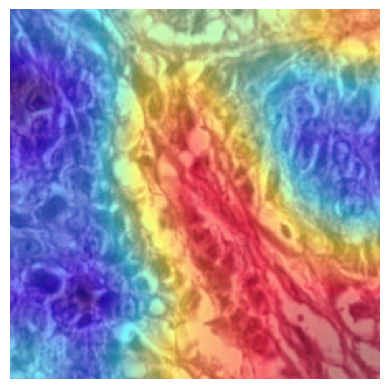

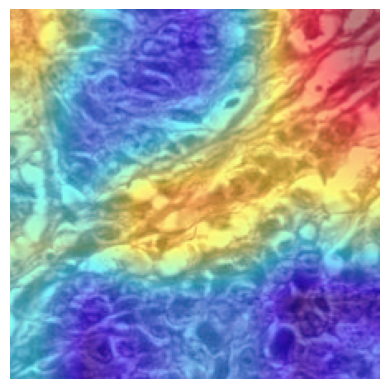

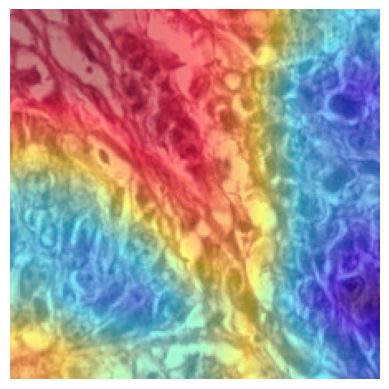

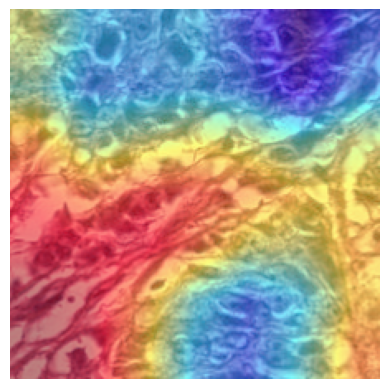

In [93]:
idx = 5947

for k in range(4):
  gc = grad_cams[k][idx][0, :]
  img = rotate_image(test_dataset[idx][0], k)
  image = np.float32(img.permute(1, 2, 0))
  visualization = show_cam_on_image(image, gc, use_rgb=False)
  plt.imshow(visualization)
  plt.axis('off')
  plt.show()
  

In [63]:
rerot_gradcams = []

for k in range(4):
    gs = torch.tensor(np.concatenate(grad_cams[k], axis=0))
    gs = rotate_image(gs, -k)
    rerot_gradcams.append(gs)

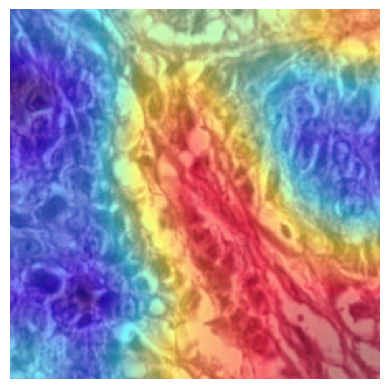

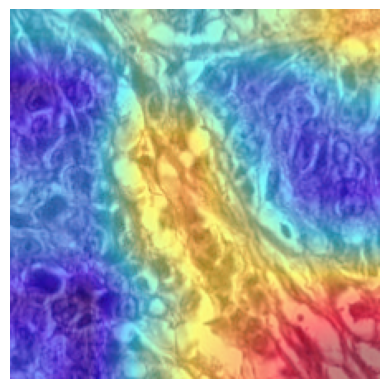

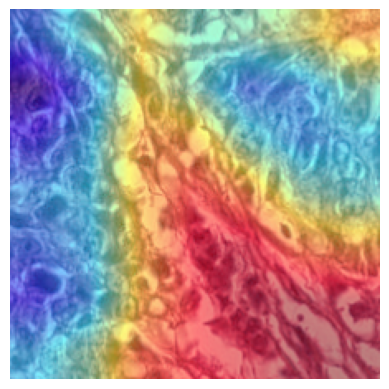

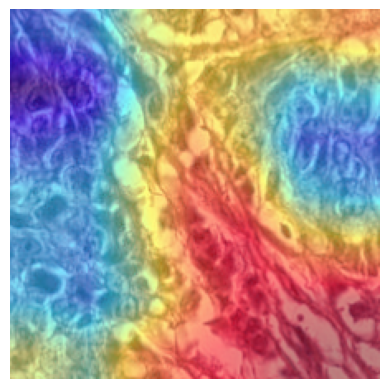

In [94]:
idx = 5947

for k in range(4):
  gc = rerot_gradcams[k][idx]
  img = test_dataset[idx][0]
  image = np.float32(img.permute(1, 2, 0))
  visualization = show_cam_on_image(image, gc, use_rgb=False)
  plt.imshow(visualization)
  plt.axis('off')
  plt.show()

In [72]:
# train discriminative model

class_begins = class_offsets.values()
class_ends = list(class_offsets.values())[1:] + [TEST_SIZE]

results = {
    'separability': [],
    'class': [],
    'rotation': []
}
for c_start, c_end in zip(class_begins, class_ends):
    class_zero = rerot_gradcams[0][c_start:c_end]
    for i in range(1, 4):
        class_i = rerot_gradcams[i][c_start:c_end]

        X = torch.cat([class_zero, class_i], dim=0)
        y = torch.cat([torch.zeros(class_zero.size(0)), torch.ones(class_i.size(0))])

        X = X.view(X.size(0), -1).cpu().numpy()
        y = y.cpu().numpy()

        clf = LogisticRegression(random_state=0, max_iter=1000)
        cv = cross_validate(clf, X, y, cv=10, n_jobs=-1, scoring='accuracy')
        
        separab = cv['test_score']
        results['separability'].extend(separab)
        results['class'].extend([class_offsets_rev[c_start]] * len(separab))
        results['rotation'].extend([i] * len(separab))
        

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [74]:
sep_df = pd.DataFrame(results)
sep_df['S'] = (sep_df['separability']-0.5).abs() *2
sep_df

,separability,class,rotation,S
0,0.973881,0,1,0.947761
1,0.973881,0,1,0.947761
2,0.981343,0,1,0.962687
3,0.985075,0,1,0.970149
4,0.973881,0,1,0.947761
...,...,...,...,...
265,0.809717,8,3,0.619433
266,0.849593,8,3,0.699187
267,0.837398,8,3,0.674797
268,0.825203,8,3,0.650407


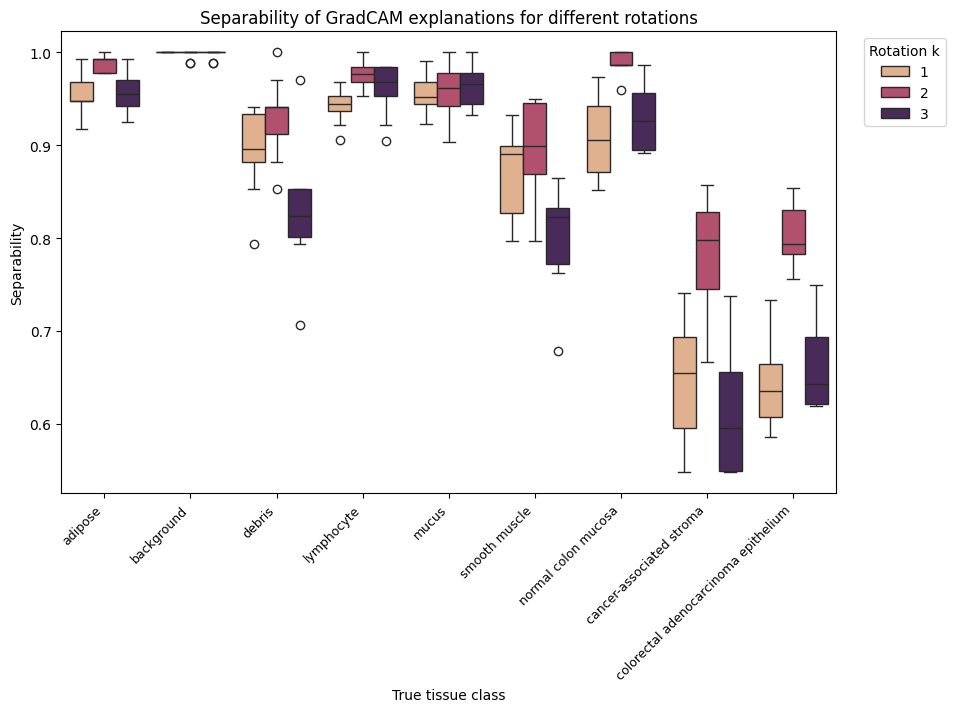

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='class', y='S', hue='rotation', data=sep_df, ax=ax, dodge=True, palette='flare')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=[tissue_labels[i] for i in range(NUM_CLASSES)], rotation=45, ha='right', fontsize=9)
plt.ylabel("Separability")
plt.xlabel("True tissue class", )
plt.legend(title="Rotation k", loc='upper right', bbox_to_anchor=(1.15, 1.),)
plt.title("Separability of GradCAM explanations for different rotations")
plt.show()

In [91]:
sep_df.to_csv("gradcam_separability.tsv", index=False, sep='\t')

In [81]:
# correlation metrics

from scipy.stats import pearsonr, spearmanr

results_corr = {
    'pearson': [],
    'spearman': [],
    'class': [],
    'rotation': []
}
for c_start, c_end in tqdm(zip(class_begins, class_ends)):
    class_zero = rerot_gradcams[0][c_start:c_end].flatten()
    for i in range(1, 4):
        class_i = rerot_gradcams[i][c_start:c_end].flatten()
        pearson_corr, _ = pearsonr(class_zero, class_i)
        spearman_corr, _ = spearmanr(class_zero, class_i)

        results_corr['pearson'].append(pearson_corr)
        results_corr['spearman'].append(spearman_corr)
        results_corr['class'].append(class_offsets_rev[c_start])
        results_corr['rotation'].append(i)



9it [04:59, 33.27s/it]


In [82]:
corr_df = pd.DataFrame(results_corr)
corr_df

,pearson,spearman,class,rotation
0,0.844584,0.842237,0,1
1,0.818502,0.815268,0,2
2,0.842046,0.839311,0,3
3,0.437642,0.449430,1,1
4,0.193771,0.216551,1,2
5,0.431736,0.440543,1,3
6,0.758189,0.756852,2,1
7,0.751150,0.744673,2,2
8,0.787317,0.785795,2,3
9,0.632535,0.616208,3,1


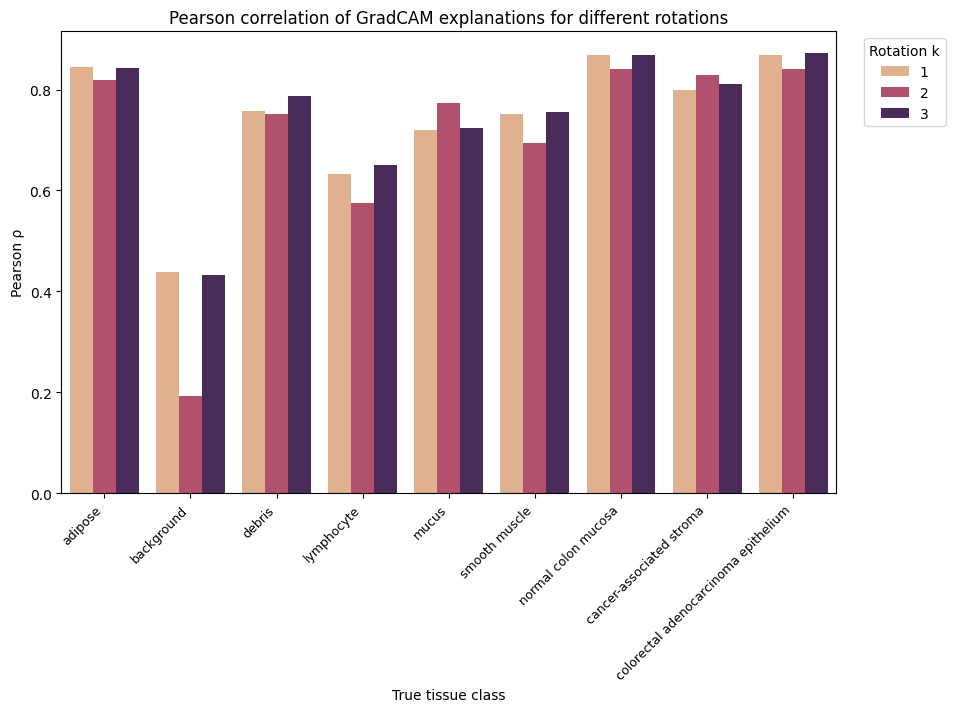

In [88]:
groups = corr_df.groupby(['class', 'rotation'])['pearson']

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='class', y='pearson', hue='rotation', data=corr_df, ax=ax, dodge=True, palette='flare')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=[tissue_labels[i] for i in range(NUM_CLASSES)], rotation=45, ha='right', fontsize=9)
plt.ylabel("Pearson ⍴")
plt.xlabel("True tissue class", )
plt.legend(title="Rotation k", loc='upper right', bbox_to_anchor=(1.15, 1.),)
plt.title("Pearson correlation of GradCAM explanations for different rotations")
plt.show()

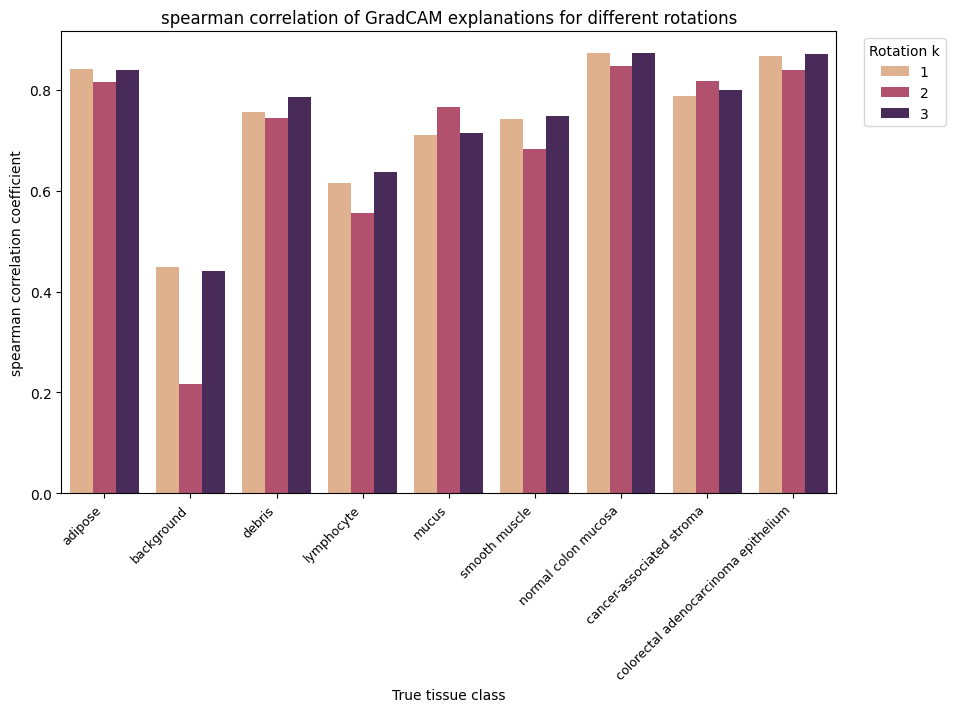

In [92]:
groups = corr_df.groupby(['class', 'rotation'])['spearman']

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='class', y='spearman', hue='rotation', data=corr_df, ax=ax, dodge=True, palette='flare')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=[tissue_labels[i] for i in range(NUM_CLASSES)], rotation=45, ha='right', fontsize=9)
plt.ylabel("spearman correlation coefficient")
plt.xlabel("True tissue class", )
plt.legend(title="Rotation k", loc='upper right', bbox_to_anchor=(1.15, 1.),)
plt.title("spearman correlation of GradCAM explanations for different rotations")
plt.show()

In [90]:
corr_df.to_csv("gradcam_correlations.tsv", index=False, sep='\t')

In [66]:
np.savez('explanations/gradcams.npz', k0=rerot_gradcams[0], k1=rerot_gradcams[1], k2=rerot_gradcams[2], k3=rerot_gradcams[3])


In [95]:
test = np.load('explanations/gradcams.npz')
test['k0'].shape

(7180, 224, 224)